In [1]:
import numpy as np
from skimage.transform import resize
import tensorflow as tf
#import tensorflow_probability as tfp
sess = tf.Session()
from keras import backend as K
K.set_session(sess)

from tensorflow.python.keras.layers import *
from tensorflow.python.keras.layers import ELU
from keras.losses import binary_crossentropy
from tensorflow.python.ops import array_ops
from tensorflow.python.keras.layers import Conv2D, Lambda, Dense, Multiply, Add
from tensorflow.initializers import glorot_normal, lecun_normal
from scipy.ndimage import median_filter
from skimage.transform import resize

import os
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
def downPixelAggr(img, SCALE=2):
    from scipy import signal
    import skimage.measure
    from scipy.ndimage.filters import gaussian_filter
    img = resize(img, ((24, 24, 6)), 0)

    img_blur = np.zeros(img.shape)
    # Filter the image with a Gaussian filter
    for i in range(0, img.shape[2]):
        img_blur[:, :, i] = gaussian_filter(img[:, :, i], 1/SCALE)
    # New image dims
    new_dims = tuple(s//SCALE for s in img.shape)
    img_lr = np.zeros(new_dims[0:2]+(img.shape[-1],))
    # Iterate through all the image channels with avg pooling (pixel aggregation)
    for i in range(0, img.shape[2]):
        img_lr[:, :, i] = skimage.measure.block_reduce(img_blur[:, :, i], (SCALE, SCALE), np.mean)
        
    img_lr = resize(img_lr, ((48, 48, 6)), 0)

    return np.squeeze(img_lr)


# Load train data

In [3]:
data = []
files = [x for x in os.listdir("../../data/train-raw/") if ".npy" in x]
for file in files:
    data.append(np.load("../../data/train-raw/" + file))
data = np.concatenate(data, axis = 0)
data = np.float32(data) / 65535
print(data.shape)

(3126, 48, 48, 10)


# Load test data

In [4]:
test_data = []
files = [x for x in os.listdir("../../data/test-raw/") if ".npy" in x]
for file in files:
    test_data.append(np.load("../../data/test-raw/" + file)[:5])
test_data = np.concatenate(test_data, axis = 0)
test_data = np.float32(test_data) / 65535
print(test_data.shape)

(5504, 48, 48, 10)


In [5]:
def make_input_data(data):
    # 10 meter band, 20 -> 40 meter band, 20 meter band
    twentym = data[..., 4:]
    labels = np.copy(twentym)
    twentym = np.reshape(twentym, ((twentym.shape[0], 24, 2, 24, 2, 6)))
    twentym = np.mean(twentym, axis = (2, 4))
    tenm = data[..., :4]

    fourty_m = np.zeros_like(data[..., 4:])
    for sample in range(fourty_m.shape[0]):
        fourty_m[sample] = downPixelAggr(twentym[sample])

    bilinear_upsample = resize(fourty_m, (fourty_m.shape[0], 48, 48, 6), 2)
    input_data = np.concatenate([tenm, fourty_m], axis = -1)
    
    return bilinear_upsample, input_data, labels

def evaluate(test_data):
    n_batches = test_data.shape[0] // 32
    print(n_batches)
    test_ids = np.arange(test_data.shape[0])
    rmses = np.empty((n_batches, 6))
    for batch in range(10):
        batch_ids = test_ids[batch*32: (batch+1) * 32]
        bilinear_upsample, input_data, labels_ = make_input_data(test_data[batch_ids])
        y = sess.run([skipconnect], feed_dict={inp: input_data,
                                         bilinear_input: bilinear_upsample,
                                         labels: labels_,
                                         is_training: True,
                                         })
        y = np.concatenate(y)
        se = (labels_ - y)**2
        mse = np.mean(se, axis = (0, 1, 2))
        rmse = np.sqrt(mse)
        rmses[batch] = rmse
    rmses = np.mean(rmses, 0)
    return rmses

def make_test_data(data):
    input_data = data
    twentym = data[..., 4:]
    twentym = np.reshape(twentym, ((twentym.shape[0], 24, 2, 24, 2, 6)))
    twentym = np.mean(twentym, axis = (2, 4))
    bilinear_upsample = resize(twentym, (twentym.shape[0], 48, 48, 6), 2)
    return bilinear_upsample, input_data

In [19]:
print(evaluate(test_data))

172
[0.22769031 0.15963804 0.14597567 0.1752586  0.187959   0.21501072]


In [6]:
def conv_relu(inp, 
                 is_training, 
                 scope,
                 kernel_size,
                 filters, 
                 stride = (1, 1),
                 activation = True,
                 use_bias = True):
    '''2D convolution, batch renorm, relu block, 3x3 drop block. 
       Use_bias must be set to False for batch normalization to work. 
       He normal initialization is used with batch normalization.
       RELU is better applied after the batch norm.
       DropBlock performs best when applied last, according to original paper.
          
    '''

    with tf.variable_scope(scope + "_conv"):
        conv = Conv2D(filters = filters, kernel_size = (kernel_size, kernel_size),  strides = stride,
                      activation = None, padding = 'valid', use_bias = use_bias,
                      kernel_initializer = tf.keras.initializers.he_normal())(inp)
    if activation:
        conv = tf.nn.relu(conv)
    return conv

class ReflectionPadding2D(Layer):
    def __init__(self, padding=(1, 1), **kwargs):
        self.padding = tuple(padding)
        self.input_spec = [InputSpec(ndim=4)]
        super(ReflectionPadding2D, self).__init__(**kwargs)

    def compute_output_shape(self, s):
        """ If you are using "channels_last" configuration"""
        return (s[0], s[1] + 2 * self.padding[0], s[2] + 2 * self.padding[1], s[3])

    def call(self, x, mask=None):
        w_pad,h_pad = self.padding
        return tf.pad(x, [[0,0], [h_pad,h_pad], [w_pad,w_pad], [0,0] ], 'REFLECT')
    
def resblock(inp, is_training, scope, filters):
    inp_pad = ReflectionPadding2D()(inp)
    conv = conv_relu(inp_pad, is_training, scope + "1", 3, filters, activation = True, use_bias = True)
    conv_pad = ReflectionPadding2D()(conv)
    conv2 =  conv_relu(conv_pad, is_training, scope + "2", 3, filters, activation = False, use_bias = True)
    conv2 = tf.multiply(conv2, tf.constant(0.2))
    add = tf.add(inp, conv2)
    return add
    
    

In [7]:
inp = tf.placeholder(tf.float32, shape=(None, 48, 48, 10))
bilinear_input = tf.placeholder(tf.float32, shape = (None, 48, 48, 6))
labels =  tf.placeholder(tf.float32, shape = (None, 48, 48, 6))
is_training = tf.placeholder_with_default(False, (), 'is_training')

In [8]:
inp_pad = ReflectionPadding2D()(inp)
conv1 = conv_relu(inp_pad, is_training, "out", 3, 48, activation = True)
print(conv1.shape)
conv2 = resblock(conv1, is_training, "one", 48)
conv4 = resblock(conv2, is_training, "three", 48)
print(conv4.shape)
conv5 = resblock(conv4, is_training, "four", 48)
print(conv5.shape)
outconv = conv_relu(conv5, is_training, "out", 1, 6, activation = False)
skipconnect = tf.add(bilinear_input, outconv)


Instructions for updating:
Colocations handled automatically by placer.
(?, 48, 48, 48)
(?, 48, 48, 48)
(?, 48, 48, 48)


In [9]:
total_parameters = 0
for variable in tf.trainable_variables():
    shape = variable.get_shape()
    variable_parameters = 1
    for dim in shape:
        variable_parameters *= dim.value
    total_parameters += variable_parameters
print("This model has {} parameters".format(total_parameters))

This model has 129366 parameters


In [10]:
optimizer = tf.train.AdamOptimizer(1e-3)
loss_fn = tf.keras.losses.MAE(labels, skipconnect)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(loss_fn)   
        

init_op = tf.global_variables_initializer()
sess.run(init_op)
saver = tf.train.Saver(max_to_keep = 150)
print("The graph has been finalized")

Instructions for updating:
Use tf.cast instead.
The graph has been finalized


In [11]:
rmses = np.empty((150, 6))

In [81]:
from tqdm import tnrange, tqdm_notebook
losses = []
train_ids = np.arange(data.shape[0])
n_batches = data.shape[0] // 32
for i in range(1, 150):
    np.random.shuffle(train_ids)
    for k in tnrange(n_batches - 70):
        batch_ids = train_ids[k*32: (k+1) * 32]
        batch = data[batch_ids]
        bilinear_upsample, input_data, labels_ = make_input_data(batch)
        opt, tr = sess.run([train_op, loss_fn],
                          feed_dict={inp: input_data,
                                     bilinear_input: bilinear_upsample,
                                     labels: labels_,
                                     is_training: True,
                                     })
        losses.append(np.mean(tr))
    print(i, np.mean(tr))
    rmse = evaluate(test_data)
    print(rmse)
    rmses[i, :] = rmse


1 0.015061725
172
[0.00126213 0.00140866 0.00164713 0.00146077 0.00111346 0.00156832]



2 0.011160459
172
[0.14151026 0.14338971 0.13862609 0.13788396 0.13824384 0.14312354]



3 0.012884253
172
[0.34689811 0.36612264 0.2294597  0.16293946 0.1656559  0.29641659]



4 0.0108145885
172
[             nan              nan              nan -1.42310937e+298
              nan              nan]



5 0.010731254
172
[0.00093881 0.00106684 0.00113028 0.00125144 0.00091345 0.00108773]



6 0.010959901
172
[0.00088371 0.00104594 0.00104179 0.00113983 0.00096082 0.00103937]



7 0.009336832
172
[-3.79453960e+06 -2.13599760e+10 -2.03653380e+03  1.09334693e-03
 -1.34181014e+06 -1.01224670e+08]



8 0.008279324
172
[0.00085877 0.00108892 0.00097958 0.00100918 0.00090352 0.0009074 ]



9 0.008737101
172
[0.00075999 0.00121009 0.00115852 0.00104229 0.00084807 0.00098421]



10 0.008064453
172
[             nan              nan              nan -1.42310937e+298
              nan              nan]


KeyboardInterrupt: 

In [108]:
bilinear_upsample, input_data = make_test_data(test_data[1212][np.newaxis, :])
y = sess.run([skipconnect], feed_dict={inp: input_data,
                                 bilinear_input: bilinear_upsample,
                                 labels: labels_,
                                 is_training: True,
                                 })

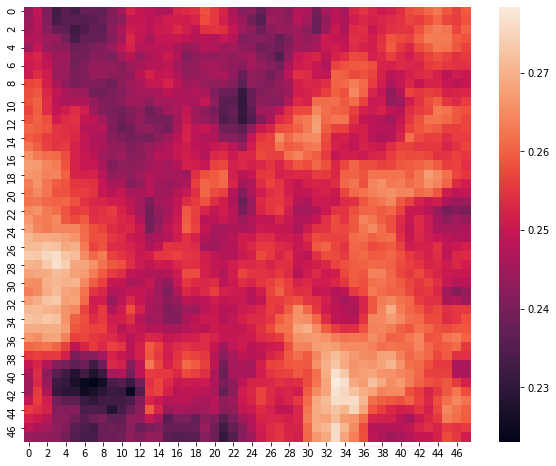

In [109]:
plt.figure(figsize=(10,8))
sns.heatmap(y[0][0, :, :,3])

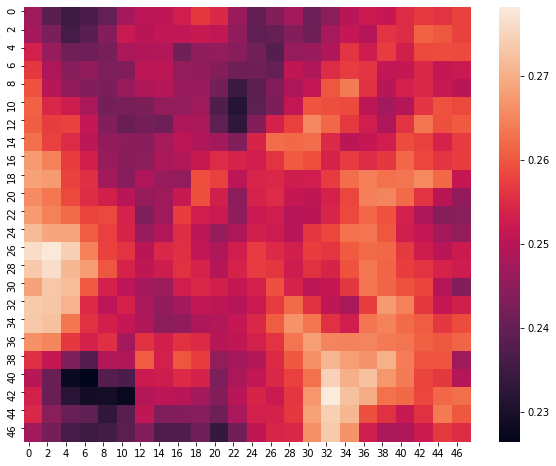

In [110]:
plt.figure(figsize=(10,8))
sns.heatmap(input_data[0, :, :, 4 + 3])